In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn.metrics import roc_auc_score, matthews_corrcoef, accuracy_score, average_precision_score, confusion_matrix, f1_score

Lines= []
f = open(r'C:\Users\katuwawalaai\Disprot\LipidBinding\Purified_Datasets\LipidPurified_TestSetAnnotations_Sep7.txt')
for line in f:
    data_line = line.rstrip().split('\t')
    Lines.append(data_line)

In [2]:
ID=[]
Sequence=[]
Binding_Annotation =[]
Disorder_Annotation =[]
J = len(Lines)-3
b =0
for b in range(0,J,4):
    ID.append(Lines[b][0])
    Sequence.append(list(Lines[b+1][0]))
    Binding_Annotation.append(list(Lines[b+2][0]))
    Disorder_Annotation.append(list(Lines[b+3][0]))

In [3]:
len(ID)

219

In [4]:
ID[16]

'>P69428'

In [5]:
#Getting length of each protein to a list
Length_EachProtein = []
b=0
for b in range(0,len(Sequence),1):
                   c = len(Sequence[b])
                   Length_EachProtein.append(c)

#Getting continous sum off All proteins to an array
d=np.cumsum(Length_EachProtein)

In [6]:
Regions=[]
Order_Indexes=[]
b=0
for b in range(0,len(Disorder_Annotation),1):
         protein=Disorder_Annotation[b]
         sequence=Sequence[b]
         regions=[]
         orderindex=[]
         c=0
         for c in range(0,len(protein),1):
                    if protein[c]=='0':
                                   regions.append(sequence[c])
                                   orderindex.append(c)
         
         ordermargins=[]
         d = 0
         for d in range(0, len(orderindex)-1 , 1):
                            if orderindex[d+1]-orderindex[d] != 1:ordermargins.append(d+1)
                        
         regionsmul=np.split(regions,ordermargins) 
         regionind=np.split(orderindex,ordermargins) # = indexes of ordered regions in each protein
         Regions.append(regionsmul)
         Order_Indexes.append(regionind)

In [7]:
Region_Reference=[]
Region_Points=[]
b=0
for b in range(0,len(Order_Indexes),1):
           sub_prots=Order_Indexes[b]
           c=0
           for c in range(0,len(sub_prots),1):
               if len(sub_prots[c])> 6:
                          Region_Reference.append(str(ID[b])+'_R'+str(c)) # giving unique id to each region 
                          Region_Points.append([b,c])  # b,c corresponding to protein id and its region id

In [8]:
#reading the alignmnet results from individual results files generated by blastp
Lines= []
b=0
for b in range(1,142,1):
          try:
              f = open(r'C:\Users\katuwawalaai\Disprot\LipidBinding\SingleRegion_Test\BalstResults_'+str(b)+'.txt')
              for line in f:
                  data_line = line.rstrip().split('\t')
                  Lines.append(data_line)
          except:
                  Lines.append('')

In [9]:
OrderedReg=[]
Identity=[]
E_Val=[]
b=0
for b in range(0,len(Lines),1):
     try:
         TM=Lines[b][0].split(',')
         OrderedReg.append(TM[0])
         Identity.append(float(TM[2]))
         E_Val.append(float(TM[-2]))   
     except:
         a=2

In [10]:
Mapped_Regions=[]
b=0
for b in range(0,len(OrderedReg),1):
              if E_Val[b]<0.1 and Identity[b]>=90 :Mapped_Regions.append(OrderedReg[b])

In [11]:
len(Mapped_Regions)

1043

In [12]:
Region_Reference.reverse()
Region_Points.reverse()

In [13]:
def DeletebadOrder(Input_List):
            b=0
            for b in range(0,len(Region_Reference),1):
                if Region_Reference[b][1:] not in Mapped_Regions: 
                                        points=Region_Points[b]
                                        target_list=Input_List[points[0]] # getting annotation list that we gonna modify
                                        dele_indexes=Order_Indexes[points[0]][points[1]] # getting indexes to be deleted
                                        new_anno=np.delete(target_list, dele_indexes).tolist() # delete the un mapped ordered indexes and making a new list
                                        Input_List[points[0]]=new_anno # assigning modified array to designated position

In [14]:
def badOrder(Input_List):
            b=0
            for b in range(0,len(Region_Reference),1):
                if Region_Reference[b][1:] not in Mapped_Regions: 
                                                  points=Region_Points[b]
                                                  target_list=np.asarray(Input_List[points[0]]) # getting annotation list that we gonna modify
                                                  dele_indexes=Order_Indexes[points[0]][points[1]] # getting indexes to be 2 d
                                                  insertion=np.full(len(dele_indexes),2) # creating an array of X to insert
                                                  np.put(target_list, dele_indexes,insertion) # insert 2 to un mapped ordered indexes in target list
                                                  new_anno=target_list.tolist() # convert modified array back to a list 
                                                  Input_List[points[0]]=new_anno # assign modified list back to the original list of lists

In [15]:
badOrder(Disorder_Annotation)

DeletebadOrder(Binding_Annotation)
DeletebadOrder(Disorder_Annotation)
DeletebadOrder(Sequence)

In [16]:
#Getting length of each protein to a list
Length_EachProtein = []
b=0
for b in range(0,len(Sequence),1):
                   c = len(Sequence[b])
                   Length_EachProtein.append(c)

#Getting continous sum off All proteins to an array
d=np.cumsum(Length_EachProtein)

In [17]:
Binding_Annotation=np.concatenate(Binding_Annotation)
Disorder_Annotation=np.concatenate(Disorder_Annotation)

In [18]:
PuriNorm_Lipid=list(map(int,Binding_Annotation))
Disorder_Annotation=list(map(int, Disorder_Annotation))

In [19]:
Lipid_Prediction = pd.read_csv(r"C:\Users\katuwawalaai\Disprot\LipidBinding\Output_Frame_Full.csv")
Lipid_Prediction.head()

,Unnamed: 0,Annotation,Score
0,0,0,0.206150
1,1,0,0.263749
2,2,0,0.291533
3,3,0,0.282848
4,4,0,0.260235


In [20]:
Annotation = Lipid_Prediction.loc[:,('Annotation')].values
Lipid_Score = Lipid_Prediction.loc[:,('Score')].values

In [21]:
Lipid_Binary=[]
b=0
for b in range(0,len(Lipid_Score),1):
    if Lipid_Score[b]>=0.38500000000000023:Lipid_Binary.append(1)
    else:Lipid_Binary.append(0)

In [22]:
Annotation_byProteins= np.split(PuriNorm_Lipid,d)
Lipid_Score_byProteins= np.split(Lipid_Score,d)
Lipid_Binary_byProteins= np.split(Lipid_Binary,d)
Disorder_Annotation_byProteins= np.split(Disorder_Annotation,d)

In [24]:
len(Disorder_Annotation_byProteins)

220

In [25]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, accuracy_score, average_precision_score, confusion_matrix, f1_score
t=16
j=t
matthews_corrcoef(Annotation_byProteins[t], Lipid_Binary_byProteins[t])

0.6105716541821837

In [25]:
sum(Annotation_byProteins[t])/len(Annotation_byProteins[t])

0.25842696629213485

In [26]:
sum(Disorder_Annotation_byProteins[t])/len(Disorder_Annotation_byProteins[t])

1.2359550561797752

In [27]:
len(Disorder_Annotation_byProteins[t])

89

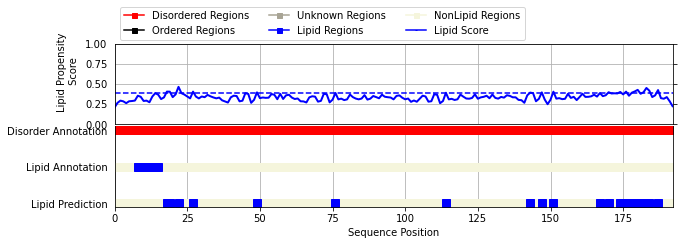

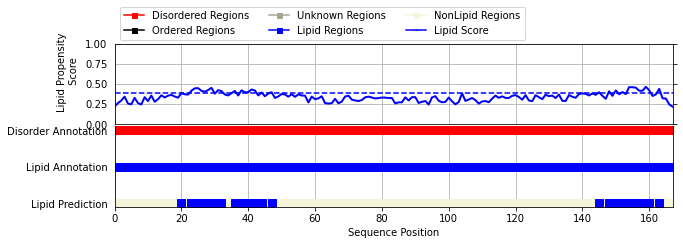

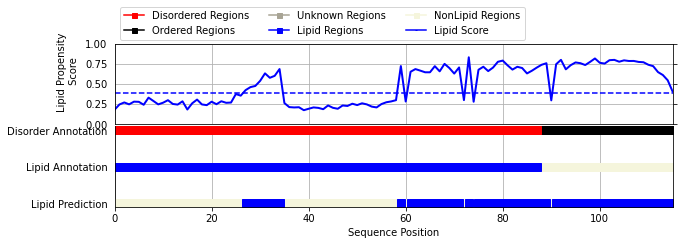

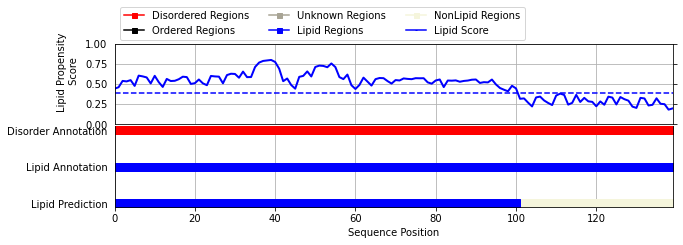

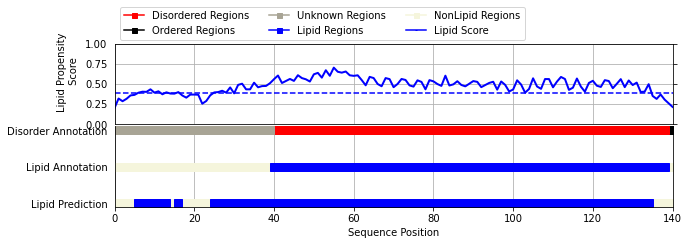

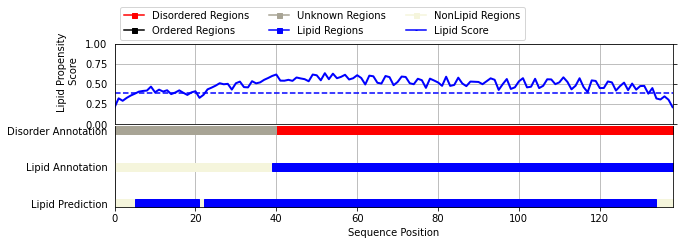

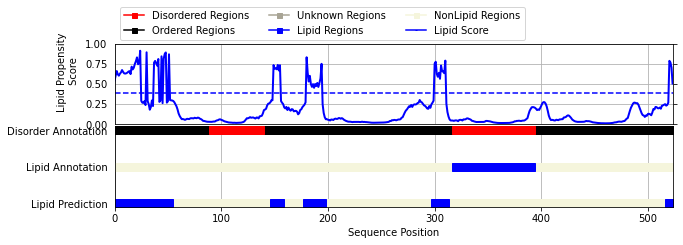

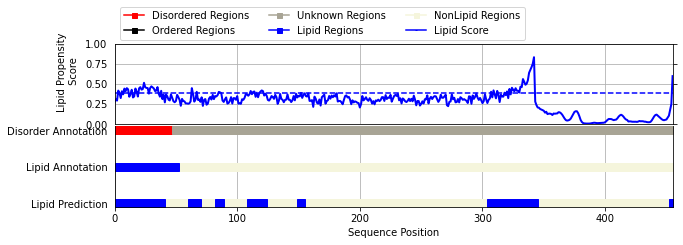

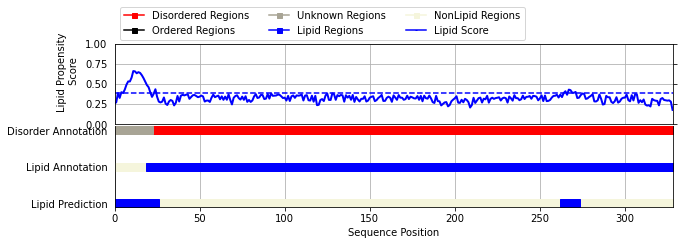

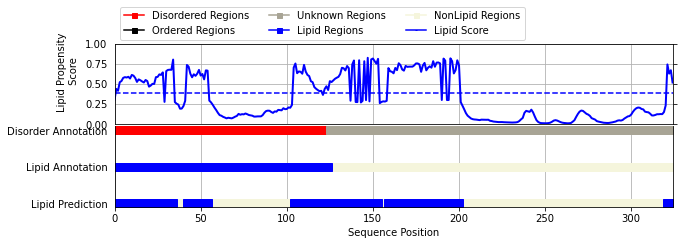

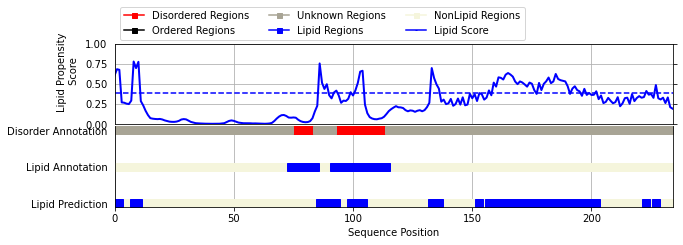

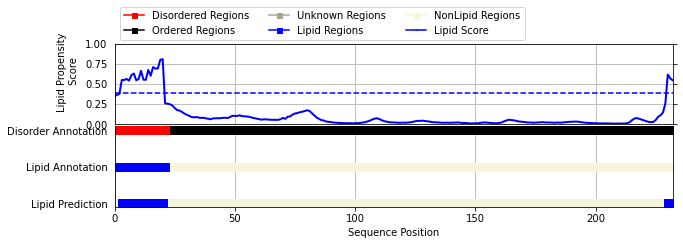

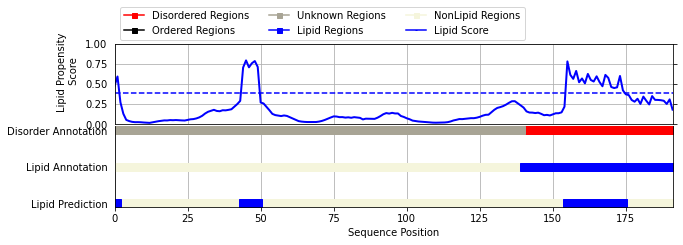

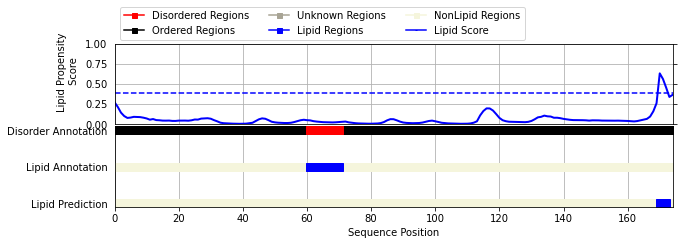

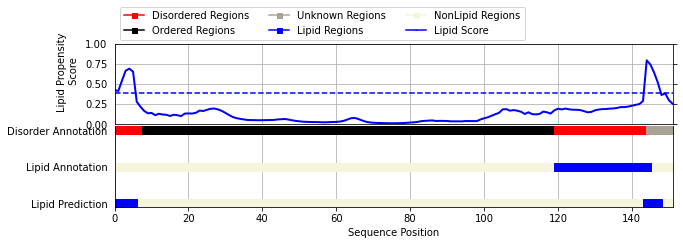

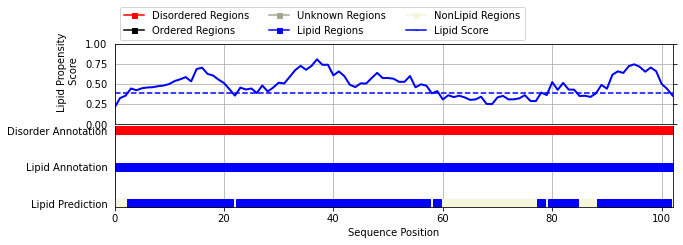

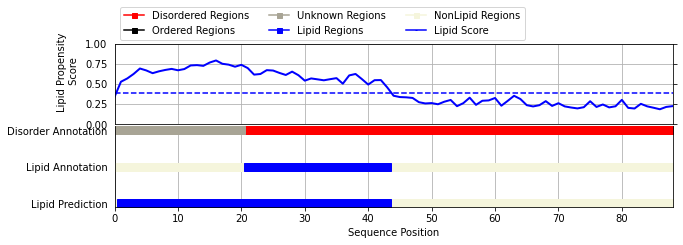

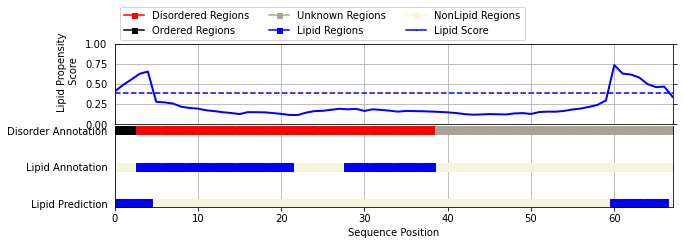

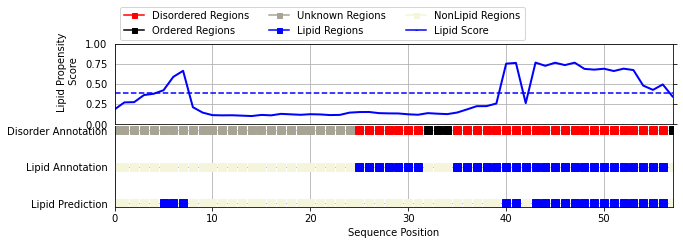

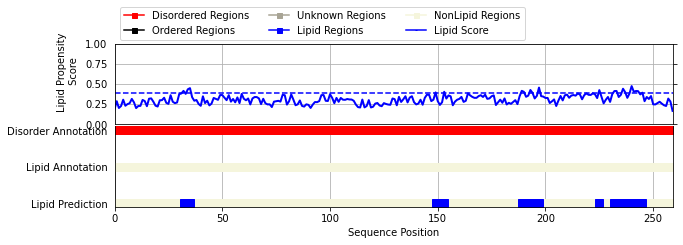

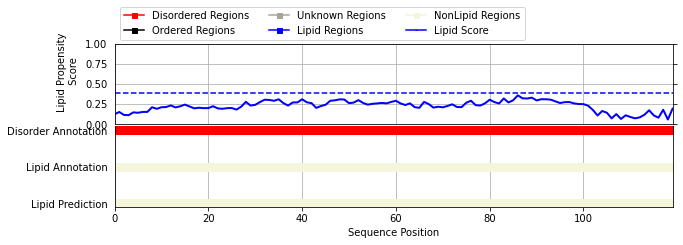

In [28]:
#16

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
j=0
for j in range(0,21,1):
       %matplotlib inline
       Position =np.arange(0,len(Annotation_byProteins[j]),1)
       size=8
       fig = plt.figure(figsize=(10,3))
       ax1 = fig.add_subplot(211)
       ax1.plot(Position, Lipid_Score_byProteins[j],'blue',label="Lipid Score",linewidth=2)
       
       ax1.hlines(y=0.38500000000000023, xmin=0, xmax=len(Position)-1, linewidth=1.5, color='blue',linestyle ='--')
       
       ax1.grid()
       #ax1.set_ylabel('  Quater+,Disopred3,SPOT-DISORDER\n and IUPred-short Predicted MCC', rotation=90, ha="right")
       fig.text(0.06,0.75, "Lipid Propensity\n Score", ha="center", va="center", rotation=90, fontsize=10)
       ax1.set_ylim([0,1.0])
       ax1.set_xlim([0,len(Position)-1])
       ax1.tick_params(top=False, bottom=False, left=False, right=True, labelleft=True, labelbottom=False)
       ax1.yaxis.set_label_coords(-0.05,1.1)
       ##################################################################################################################
       ax2 = fig.add_subplot(212)
       A = ['Lipid Prediction',
            'Lipid Annotation',
            'Disorder Annotation']
       ordercolor='black'
       unvalicolor='#a8a495'
       disordercolor='r'
       nonlipidcolor='beige'
       lipidcolor='blue'
       ##################################################################################################
       x= list(np.argwhere(Disorder_Annotation_byProteins[j]==0))
       y = np.full(len(x), 1.4)
       b=0
       for b in range(0,len(x),1):
                      ax2.plot(x[b], y[b], marker='s', markersize=size, color=ordercolor)
       #********************************************************************************************
       x= list(np.argwhere(Disorder_Annotation_byProteins[j]==1))
       y = np.full(len(x), 1.4)
       b=0
       for b in range(0,len(x),1):
                      ax2.plot(x[b], y[b], marker='s', markersize=size, color=disordercolor)
       #********************************************************************************************
       x= list(np.argwhere(Disorder_Annotation_byProteins[j]==2))
       y = np.full(len(x), 1.4)
       b=0
       for b in range(0,len(x),1):
                      ax2.plot(x[b], y[b], marker='s', markersize=size, color=unvalicolor)
       #############################################################################################
       x= list(np.argwhere(Annotation_byProteins[j]<1))
       y = np.full(len(x), 1.2)
       b=0
       for b in range(0,len(x),1):
                      ax2.plot(x[b], y[b], marker='s', markersize=size, color=nonlipidcolor)
       #********************************************************************************************
       x= list(np.argwhere(Annotation_byProteins[j]>0))
       y = np.full(len(x), 1.2)
       b=0
       for b in range(0,len(x),1):
                      ax2.plot(x[b], y[b], marker='s', markersize=size, color=lipidcolor)
       ############################################################################################
       x= list(np.argwhere(Lipid_Binary_byProteins[j]<1))
       y = np.full(len(x), 1.0)
       b=0
       for b in range(0,len(x),1):
                      ax2.plot(x[b], y[b], marker='s', markersize=size, color=nonlipidcolor)
       #********************************************************************************************
       x= list(np.argwhere(Lipid_Binary_byProteins[j]>0))
       y = np.full(len(x), 1.0)
       b=0
       for b in range(0,len(x),1):
                      ax2.plot(x[b], y[b], marker='s', markersize=size, color=lipidcolor)
       #############################################################################################
       ax2.set_xlim([0,len(Position)-1])
       ax2.yaxis.grid()
       ax2.xaxis.grid()
       #ax2.set_yticks(np.arange(1,8, 1.0))
       ticks=[1.0, 1.2, 1.4]
       ax2.set_yticks(ticks)
       ax2.set_yticklabels(A)
       ax2.get_yticklabels()[2].set_color("black")
       ax2.get_yticklabels()[1].set_color("black")
       ax2.get_yticklabels()[0].set_color("black")
       ax2.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom= True)
       ax2.spines["top"].set_visible(False)
       
       legend_elements = [Line2D([0], [0], marker='s', color=disordercolor, label='Disordered Regions',markerfacecolor=disordercolor, markersize=5),
                          Line2D([0], [0], marker='s', color=ordercolor, label='Ordered Regions',markerfacecolor=ordercolor, markersize=5),
                          Line2D([0], [0], marker='s', color=unvalicolor, label='Unknown Regions',markerfacecolor=unvalicolor, markersize=5),
                          Line2D([0], [0], marker='s', color=lipidcolor, label='Lipid Regions',markerfacecolor=lipidcolor, markersize=5),
                          Line2D([0], [0], marker='s', color=nonlipidcolor, label='NonLipid Regions',markerfacecolor=nonlipidcolor, markersize=5),
                         Line2D([0], [0], marker='_', color='blue', label='Lipid Score',markerfacecolor='#be03fd', markersize=2)]
       ax1.legend(handles=legend_elements, bbox_to_anchor=(0.01, 1.05), loc=3,ncol=3, borderaxespad=0., fontsize='medium')                    
       
       ax2.set_xlabel('Sequence Position')
       fig.subplots_adjust(wspace=0, hspace=0.03)
       #plt.savefig('Examples\Lipid_Example_'+str(j)+'.tiff', bbox_inches='tight',quality =95,orientation ='landscape',dpi =800)
       plt.show()

In [26]:
roc_auc_score(Annotation_byProteins[t], Lipid_Score_byProteins[t])

0.7332015810276681

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

Position =np.arange(0,len(Annotation_byProteins[j]),1)
fig = px.line( x=Position, y=Lipid_Score_byProteins[j], range_y=[0,1])
fig.show()